In [1]:
import torch
import os
import numpy as np

import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import pandas as pd

from model.classifier import Net as ClassNet

trained_class = './result/eta50_gpu_classification_g3train.pt'
class_model = ClassNet()
class_model.load_state_dict(torch.load(trained_class, map_location=torch.device('cpu')))
class_model.eval()
class_model = class_model.double()

print("Model Loaded")

print("Importing Data")

/tmpscratch/tkim12/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Loaded
Importing Data


In [2]:
file_loc = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

# Load background
bkg_file = 20
CMB_bkg = []
for file_num in range(bkg_file):
    Xtemp = np.load(file_loc+"quicklens_backgound/500_events_90Sqr_lensed_Backgroundlmax3500_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_bkg.append(Xtemp[k])


# Load CMB signal only (g = 1)
CMB_sig = []
for file_num in range(1,4):
    Xtemp = np.load(file_loc+"PHS_signal/500_partial_eta50PHS_g1_Sig_onLSS_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_sig.append(Xtemp[k])

In [3]:
CMB_bkg = np.array(CMB_bkg)
CMB_sig = np.array(CMB_sig)

sampsize = 500

CMB_bkg1 = np.array(random.choices(CMB_bkg, k=sampsize))

rescale_g = np.array([1, 2, 2.5, 3, 4])

CMB_bkg2 = np.array(random.choices(CMB_bkg, k=sampsize)) + rescale_g[0]*np.array(random.choices(CMB_sig, k=sampsize))
CMB_bkg3 = np.array(random.choices(CMB_bkg, k=sampsize)) + rescale_g[1]*np.array(random.choices(CMB_sig, k=sampsize))
CMB_bkg4 = np.array(random.choices(CMB_bkg, k=sampsize)) + rescale_g[2]*np.array(random.choices(CMB_sig, k=sampsize))
CMB_bkg5 = np.array(random.choices(CMB_bkg, k=sampsize)) + rescale_g[3]*np.array(random.choices(CMB_sig, k=sampsize))
CMB_bkg6 = np.array(random.choices(CMB_bkg, k=sampsize)) + rescale_g[4]*np.array(random.choices(CMB_sig, k=sampsize))


CMB_bkg1_num = CMB_bkg1.shape[0]


Y_data = np.zeros(CMB_bkg1_num)

wid, hei = CMB_bkg1.shape[1], CMB_bkg1.shape[2]
print(CMB_bkg1.shape[0], wid, hei)


CMB_bkg1 = CMB_bkg1.reshape(CMB_bkg1.shape[0], 1, wid, hei).astype('float64')
CMB_bkg1 = torch.from_numpy(CMB_bkg1)

CMB_bkg2 = CMB_bkg2.reshape(CMB_bkg2.shape[0], 1, wid, hei).astype('float64')
CMB_bkg2 = torch.from_numpy(CMB_bkg2)

CMB_bkg3 = CMB_bkg3.reshape(CMB_bkg3.shape[0], 1, wid, hei).astype('float64')
CMB_bkg3 = torch.from_numpy(CMB_bkg3)

CMB_bkg4 = CMB_bkg4.reshape(CMB_bkg4.shape[0], 1, wid, hei).astype('float64')
CMB_bkg4 = torch.from_numpy(CMB_bkg4)

CMB_bkg5 = CMB_bkg5.reshape(CMB_bkg5.shape[0], 1, wid, hei).astype('float64')
CMB_bkg5 = torch.from_numpy(CMB_bkg5)

CMB_bkg6 = CMB_bkg6.reshape(CMB_bkg6.shape[0], 1, wid, hei).astype('float64')
CMB_bkg6 = torch.from_numpy(CMB_bkg6)


Y_data = Y_data.reshape(Y_data.shape[0], 1).astype('float64')
Y_data = torch.from_numpy(Y_data)

500 90 90


In [4]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

bkg1_data = TensorDataset(CMB_bkg1, Y_data)
bkg2_data = TensorDataset(CMB_bkg2, Y_data)
bkg3_data = TensorDataset(CMB_bkg3, Y_data)
bkg4_data = TensorDataset(CMB_bkg4, Y_data)
bkg5_data = TensorDataset(CMB_bkg5, Y_data)
bkg6_data = TensorDataset(CMB_bkg6, Y_data)

bkg1loader = DataLoader(dataset=bkg1_data, batch_size=1, shuffle=False)
bkg2loader = DataLoader(dataset=bkg2_data, batch_size=1, shuffle=False)
bkg3loader = DataLoader(dataset=bkg3_data, batch_size=1, shuffle=False)
bkg4loader = DataLoader(dataset=bkg4_data, batch_size=1, shuffle=False)
bkg5loader = DataLoader(dataset=bkg5_data, batch_size=1, shuffle=False)
bkg6loader = DataLoader(dataset=bkg6_data, batch_size=1, shuffle=False)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_model = class_model.to(device)

In [6]:
print("Prediction ... ")

bkg1_outputs = []
bkg2_outputs = []
bkg3_outputs = []
bkg4_outputs = []
bkg5_outputs = []
bkg6_outputs = []


i=0
print(" Background ")
with torch.no_grad():
    for data in bkg1loader:
        i+=1
        images, y = data
        images, y = images.to(device), y.to(device)
        coutputs = class_model(images)
        
        bkg1_outputs.append(coutputs.cpu().detach().numpy())

        if i%1000==0:
            print("Event : "+str(i)+" Completed")


i=0
print(" Background with new profile g = "+str(rescale_g[0]))
with torch.no_grad():
    for data in bkg2loader:
        i+=1
        images, y = data
        images, y = images.to(device), y.to(device)
        coutputs = class_model(images)
        
        bkg2_outputs.append(coutputs.cpu().detach().numpy())

        if i%1000==0:
            print("Event : "+str(i)+" Completed")

i=0
print(" Background with new profile g = "+str(rescale_g[1]))
with torch.no_grad():
    for data in bkg3loader:
        i+=1
        images, y = data
        images, y = images.to(device), y.to(device)
        coutputs = class_model(images)
        
        bkg3_outputs.append(coutputs.cpu().detach().numpy())

        if i%1000==0:
            print("Event : "+str(i)+" Completed")

i=0
print(" Background with new profile g = "+str(rescale_g[2]))
with torch.no_grad():
    for data in bkg4loader:
        i+=1
        images, y = data
        images, y = images.to(device), y.to(device)
        coutputs = class_model(images)
        
        bkg4_outputs.append(coutputs.cpu().detach().numpy())

        if i%1000==0:
            print("Event : "+str(i)+" Completed")

i=0
print(" Background with new profile g = "+str(rescale_g[3]))
with torch.no_grad():
    for data in bkg5loader:
        i+=1
        images, y = data
        images, y = images.to(device), y.to(device)
        coutputs = class_model(images)
        
        bkg5_outputs.append(coutputs.cpu().detach().numpy())

        if i%1000==0:
            print("Event : "+str(i)+" Completed")

i=0
print(" Background with new profile g = "+str(rescale_g[4]))
with torch.no_grad():
    for data in bkg6loader:
        i+=1
        images, y = data
        images, y = images.to(device), y.to(device)
        coutputs = class_model(images)
        
        bkg6_outputs.append(coutputs.cpu().detach().numpy())

        if i%1000==0:
            print("Event : "+str(i)+" Completed")

print("Prediction done")

Prediction ... 
 Background 
 Background with new profile g = 1.0
 Background with new profile g = 2.0
 Background with new profile g = 2.5
 Background with new profile g = 3.0
 Background with new profile g = 4.0
Prediction done


In [7]:
bkg1_outputs = np.concatenate(bkg1_outputs)
bkg2_outputs = np.concatenate(bkg2_outputs)
bkg3_outputs = np.concatenate(bkg3_outputs)
bkg4_outputs = np.concatenate(bkg4_outputs)
bkg5_outputs = np.concatenate(bkg5_outputs)
bkg6_outputs = np.concatenate(bkg6_outputs)

#np.save("Background+signal_Case1_prediction", bkg1_outputs)
#np.save("Background+signal_Case2_prediction", bkg2_outputs)

In [8]:
false_g2 = np.where((bkg2_outputs>0.5).T[0]==False)[0]
true_g2 = np.where((bkg2_outputs>0.5).T[0]==True)[0]

In [9]:
#print(len(false_g2))
#print(len(true_g2))
falselist = []
truelist = []

for envts in range(len(false_g2)):
    falselist.append(CMB_sig[false_g2[envts]].max())
    

for envts in range(len(true_g2)):
    truelist.append(CMB_sig[true_g2[envts]].max())

print(np.average(falselist),np.std(falselist))
print(np.average(truelist),np.std(truelist))

8.092868434145393 1.2408009898057268
8.30050230119878 1.1912008414242656


In [10]:
bkg_rej = len(bkg1_outputs[bkg1_outputs<0.5])/sampsize*100

sig_eff1 = (100*len(bkg2_outputs[bkg2_outputs>0.5])/sampsize)
sig_eff2 = (100*len(bkg3_outputs[bkg3_outputs>0.5])/sampsize)
sig_eff3 = (100*len(bkg4_outputs[bkg4_outputs>0.5])/sampsize)
sig_eff4 = (100*len(bkg5_outputs[bkg5_outputs>0.5])/sampsize)
sig_eff5 = (100*len(bkg6_outputs[bkg6_outputs>0.5])/sampsize)

In [11]:
print(100*len(bkg2_outputs[bkg2_outputs>0.5])/sampsize)
print(100*len(bkg3_outputs[bkg3_outputs>0.5])/sampsize)
print(100*len(bkg4_outputs[bkg4_outputs>0.5])/sampsize)
print(100*len(bkg5_outputs[bkg5_outputs>0.5])/sampsize)
print(100*len(bkg6_outputs[bkg6_outputs>0.5])/sampsize)

1.6
8.4
18.0
27.4
39.2


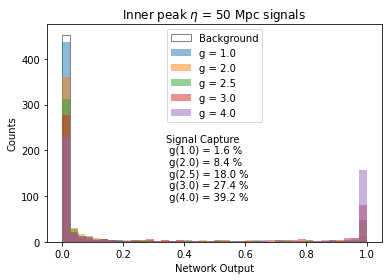

In [14]:
import matplotlib.pyplot as plt

bins=np.linspace(0,1,num=41)

kwargs = dict(alpha=0.5, bins=bins)

plt.hist(bkg1_outputs,**kwargs,label=f'Background',histtype=u'step',color='black')
plt.hist(bkg2_outputs,**kwargs,label=f'g = {rescale_g[0]:.1f}')
plt.hist(bkg3_outputs,**kwargs,label=f'g = {rescale_g[1]:.1f}')
plt.hist(bkg4_outputs,**kwargs,label=f'g = {rescale_g[2]:.1f}')
plt.hist(bkg5_outputs,**kwargs,label=f'g = {rescale_g[3]:.1f}')
plt.hist(bkg6_outputs,**kwargs,label=f'g = {rescale_g[4]:.1f}')

plt.figtext(.4, .27, f'Signal Capture \n g({rescale_g[0]:.1f}) = {sig_eff1:.1f} % \n g({rescale_g[1]:.1f}) = {sig_eff2:.1f} % \n g({rescale_g[2]:.1f}) = {sig_eff3:.1f} % \n g({rescale_g[3]:.1f}) = {sig_eff4:.1f} % \n g({rescale_g[4]:.1f}) = {sig_eff5:.1f} %')

plt.title(r"Inner peak $\eta$ = 50 Mpc signals")

plt.xlabel("Network Output")
plt.ylabel("Counts")
plt.legend(loc='upper center')
plt.savefig("eta50_inner_peak_test.pdf",bbox_inches='tight')